# Image Classification:  Fungi Identification
# Wrangling and EDA

Images were obtained from UCI Machine Learning Repository: https://archive.ics.uci.edu/dataset/773/defungi.  Original paper at https://arxiv.org/abs/2109.07322#.  Images are organized by folder.


In [1]:
# imports cribbed and cleaned from https://www.kaggle.com/code/anshtanwar/is-your-pet-sad-resnet-densenet-efficientnet
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from keras.utils import np_utils, plot_model
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

from IPython.display import display, Image
import PIL

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
directory = "fungi images"
subdirs = ["\h1", "\h2", "\h3", "\h5", "\h6"]

Folder fungi images\h1 has 4404 files.
Folder fungi images\h2 has 2334 files.
Folder fungi images\h3 has 819 files.
Folder fungi images\h5 has 818 files.
Folder fungi images\h6 has 739 files.


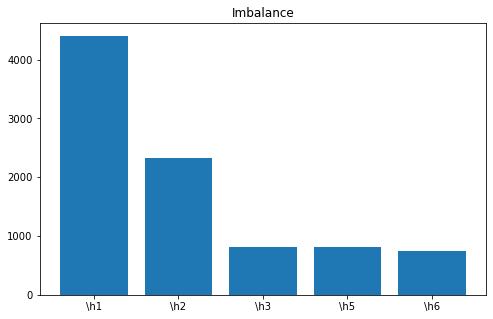

In [3]:
labels = []
num_files = []
for subdir in subdirs:
    path = directory + subdir
    print(f"Folder {path} has {len(os.listdir(path))} files.")
    labels.append(subdir)
    num_files.append(len(os.listdir(path)))
fig = plt.figure(figsize=(8,5))
plt.bar(labels, num_files)
plt.title("Imbalance")
plt.show()

So, our classes are less than perfectly balanced.  Let's sample some images.

In [4]:
# obtain images as list by folder
def folder_images(source):
    images = []
    for filename in os.listdir(source):
        images.append(filename)
    return images

In [5]:
h1 = folder_images("fungi images\h1")
h2 = folder_images("fungi images\h2")
h3 = folder_images("fungi images\h3")
h5 = folder_images("fungi images\h5")
h6 = folder_images("fungi images\h6")

In [6]:
# sample some images
h1[303:313]

['H1_106c_3.jpg',
 'H1_106c_4.jpg',
 'H1_106c_5.jpg',
 'H1_106c_6.jpg',
 'H1_106c_7.jpg',
 'H1_106c_8.jpg',
 'H1_106c_9.jpg',
 'H1_107a_1.jpg',
 'H1_107a_10.jpg',
 'H1_107a_11.jpg']

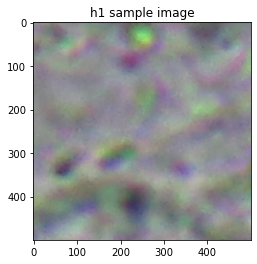

In [7]:
plt.title("h1 sample image")
image = mpimg.imread("fungi images\\h1\\"+h1[3552])
plt.imshow(image)
plt.show()

In [8]:
# using PIL which is new to me
image = PIL.Image.open("fungi images\\h1\\"+h1[3552])
image.show()

Whoa!  That opened the image in my system default app for opening .jpg files!  Not at all what was expected - but PIL might prove useful for checking image sizes.  For now, I'm going to use pyplot for the images, and examine more of them.

In [38]:
def rand_imgs_folder(source, num_imgs=4, max_cols=4, figsize=(12,8)):
    # load and randomly select images
    images = []
    for filename in os.listdir(source):
        images.append(filename)
    imgs = np.random.choice(images, num_imgs)
    
    # establish rows and columns    
    if num_imgs <= max_cols:
        cols = num_imgs
        rows = 1
    elif num_imgs > max_cols:
        cols = max_cols
        rows = int(np.ceil(num_imgs / max_cols))
    
    if num_imgs > 16:
        figsize=(20,14)
    elif num_imgs > 8:
        figsize=(16,11)
    
    # organize and draw the figure
    f = plt.figure(figsize=figsize)
    f.axis('off')
    t = f"Images from {source}"
    plt.title(t)
    img_index = 0                                    # I hate this, but it works and I can't be bothered
    for img in imgs:
        img_index +=1
        f.add_subplot(rows, cols, img_index)
        image = mpimg.imread(source+"\\"+img)
        plt.imshow(image)
        plt.axis('off')
        plt.title(img)
    plt.show()

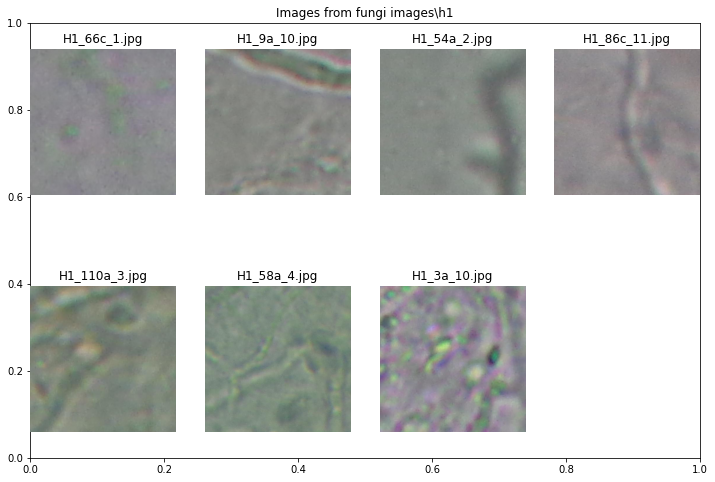

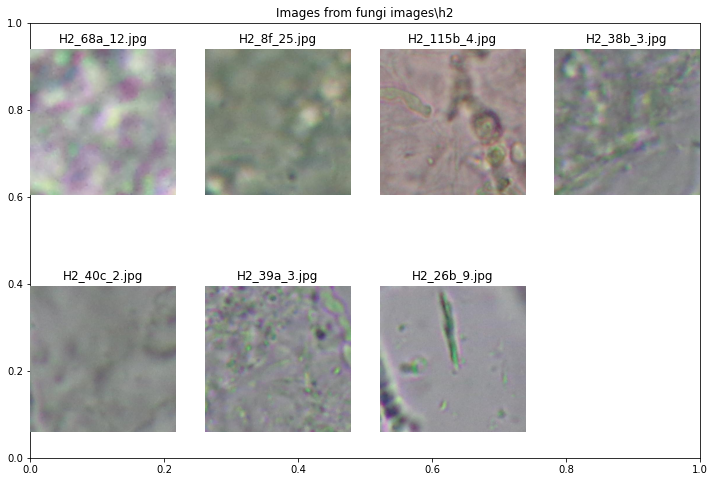

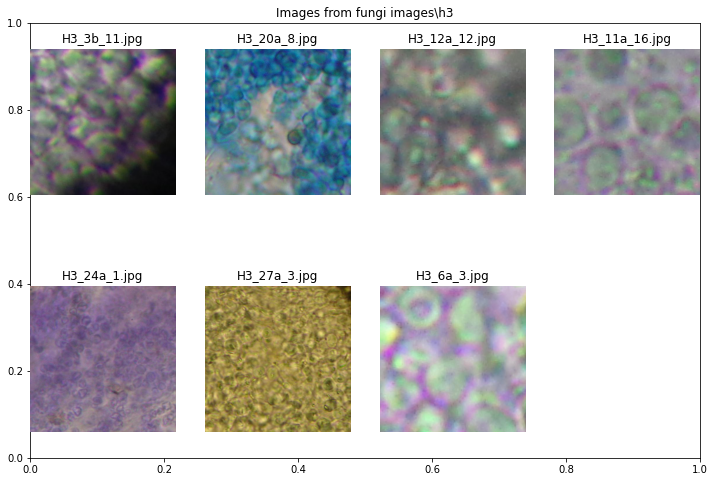

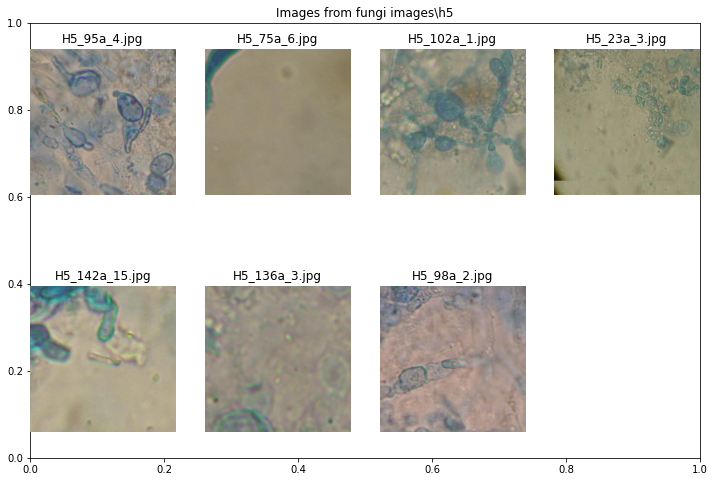

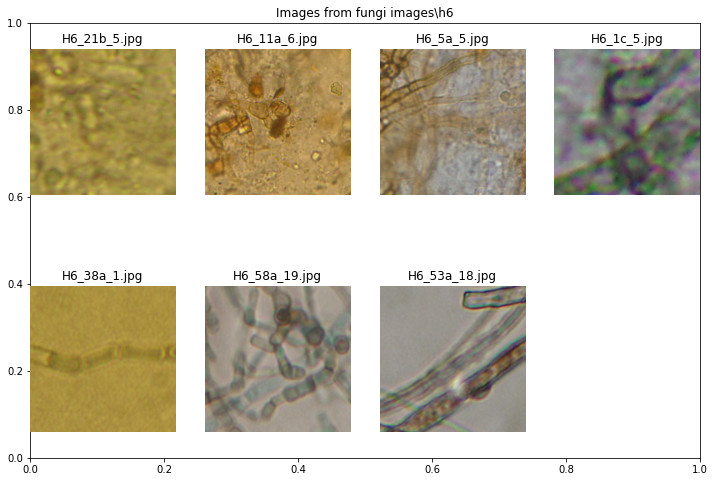

In [10]:
rand_imgs_folder("fungi images\h1", num_imgs=7)
rand_imgs_folder("fungi images\h2", num_imgs=7)
rand_imgs_folder("fungi images\h3", num_imgs=7)
rand_imgs_folder("fungi images\h5", num_imgs=7)
rand_imgs_folder("fungi images\h6", num_imgs=7)

Ok, this function could be improved a bit but it works.  We can see some variation between the classes, yes.  I do worry, though, that some of this could be artifactual - we just don't know enough about the source to be certain.  Many of the images seem out of focus or just totally indistinct.  I'm concerned that one set seems to be very nearly monochrome, and the others not.  This would certainly make predicting that class easy, right?  I'll have to account for this, moving forward; intuition suggests that converting these images to grayscale would be wise.  But I should also check the image sizes.

In [11]:
# check image sizes

def check_image_sizes(source):
    sizes = []
    for filename in os.listdir(source):
        image = PIL.Image.open(source+filename)
        size = [image.width, image.height]
        sizes.append(size)
    return sizes


In [12]:
h1sizes = check_image_sizes("fungi images\\h1\\")
h2sizes = check_image_sizes("fungi images\\h2\\")
h3sizes = check_image_sizes("fungi images\\h3\\")
h5sizes = check_image_sizes("fungi images\\h5\\")
h6sizes = check_image_sizes("fungi images\\h6\\")

In [13]:
# explore a little
h2sizes[200:210]

[[500, 500],
 [500, 500],
 [500, 500],
 [500, 500],
 [500, 500],
 [500, 500],
 [500, 500],
 [500, 500],
 [500, 500],
 [500, 500]]

In [14]:
# of course no amount of exploring will verify this, let's be systematic:
def check_list_identical(list):
    return all(element == list[0] for element in list)


In [15]:
check_list_identical(h6sizes)

True

It would appear that all images in this dataset are sized at 500 x 500 pixels.  I was hoping to do a little more preprocessing for this capstone; perhaps I'll pick a different image library.  However, I think I'll continue this as an exercise.

# Model Exploration

As this is my first effort to build an image classifier, I'm starting by examining some samples from kaggle:


Simple and accessible:
https://www.kaggle.com/code/guanlintao/mobilenetv3large-simple-jellyfish-image-predict


Primitive and skeletal, achieved a 49% test accuracy:
https://www.kaggle.com/code/mansi0123/jellyfish-types-using-tensorflow


Some things seem a bit sketchy but I like the loss tracking and confusion matrix stuff:
https://www.kaggle.com/code/banddaniel/jellyfish-detect-10cv-custom-convmixer-f1-0-87
    
And I'm going to start with a simple classifier, with simple analysis. 

In [16]:
from PIL import Image

In [17]:
# this isn't great but using a dict seems to be the best easy way 

labels = {'h1': 0,
         'h2': 1,
         'h3': 2,
         'h5': 3,
         'h6': 4}

X=[]
Y=[]

for dir, label in labels.items():
    path = "fungi images\\"+dir
    img_files = os.listdir(path)
    for file in img_files:
        #X.append(mpimg.imread(path+"\\"+file))
        # With 500x500x3 image sizes, I was getting runtimes around 15 mins/epoch for batch sizes of 20.  
        # Need to rescale images and maybe grayscale them.
        X.append(Image.open(path+"\\"+file).resize((200, 200), Image.ANTIALIAS))
        Y.append(label)
        print("file "+path+"\\"+file+" appended")



file fungi images\h1\H1_100a_1.jpg appended
file fungi images\h1\H1_100a_2.jpg appended
file fungi images\h1\H1_100a_3.jpg appended
file fungi images\h1\H1_100a_4.jpg appended
file fungi images\h1\H1_100a_5.jpg appended
file fungi images\h1\H1_100a_6.jpg appended
file fungi images\h1\H1_100a_7.jpg appended
file fungi images\h1\H1_100a_8.jpg appended
file fungi images\h1\H1_100a_9.jpg appended
file fungi images\h1\H1_101a_1.jpg appended
file fungi images\h1\H1_101a_2.jpg appended
file fungi images\h1\H1_101a_3.jpg appended
file fungi images\h1\H1_101a_4.jpg appended
file fungi images\h1\H1_101a_5.jpg appended
file fungi images\h1\H1_101a_6.jpg appended
file fungi images\h1\H1_101a_7.jpg appended
file fungi images\h1\H1_101a_8.jpg appended
file fungi images\h1\H1_101a_9.jpg appended
file fungi images\h1\H1_101b_1.jpg appended
file fungi images\h1\H1_101b_10.jpg appended
file fungi images\h1\H1_101b_11.jpg appended
file fungi images\h1\H1_101b_12.jpg appended
file fungi images\h1\H1_101b_

file fungi images\h1\H1_104c_4.jpg appended
file fungi images\h1\H1_104c_5.jpg appended
file fungi images\h1\H1_104c_6.jpg appended
file fungi images\h1\H1_104c_7.jpg appended
file fungi images\h1\H1_104c_8.jpg appended
file fungi images\h1\H1_104c_9.jpg appended
file fungi images\h1\H1_105a_1.jpg appended
file fungi images\h1\H1_105a_10.jpg appended
file fungi images\h1\H1_105a_11.jpg appended
file fungi images\h1\H1_105a_12.jpg appended
file fungi images\h1\H1_105a_13.jpg appended
file fungi images\h1\H1_105a_14.jpg appended
file fungi images\h1\H1_105a_15.jpg appended
file fungi images\h1\H1_105a_16.jpg appended
file fungi images\h1\H1_105a_17.jpg appended
file fungi images\h1\H1_105a_18.jpg appended
file fungi images\h1\H1_105a_19.jpg appended
file fungi images\h1\H1_105a_2.jpg appended
file fungi images\h1\H1_105a_20.jpg appended
file fungi images\h1\H1_105a_3.jpg appended
file fungi images\h1\H1_105a_4.jpg appended
file fungi images\h1\H1_105a_5.jpg appended
file fungi images\h1\

file fungi images\h1\H1_10a_5.jpg appended
file fungi images\h1\H1_10a_6.jpg appended
file fungi images\h1\H1_10a_7.jpg appended
file fungi images\h1\H1_10a_8.jpg appended
file fungi images\h1\H1_10a_9.jpg appended
file fungi images\h1\H1_10b_1.jpg appended
file fungi images\h1\H1_10b_2.jpg appended
file fungi images\h1\H1_10b_3.jpg appended
file fungi images\h1\H1_10b_4.jpg appended
file fungi images\h1\H1_10b_5.jpg appended
file fungi images\h1\H1_10b_6.jpg appended
file fungi images\h1\H1_10c_1.jpg appended
file fungi images\h1\H1_10c_2.jpg appended
file fungi images\h1\H1_10c_3.jpg appended
file fungi images\h1\H1_10c_4.jpg appended
file fungi images\h1\H1_110a_1.jpg appended
file fungi images\h1\H1_110a_2.jpg appended
file fungi images\h1\H1_110a_3.jpg appended
file fungi images\h1\H1_110a_4.jpg appended
file fungi images\h1\H1_110a_5.jpg appended
file fungi images\h1\H1_110a_6.jpg appended
file fungi images\h1\H1_110a_7.jpg appended
file fungi images\h1\H1_110a_8.jpg appended
fil

file fungi images\h1\H1_115a_24.jpg appended
file fungi images\h1\H1_115a_25.jpg appended
file fungi images\h1\H1_115a_3.jpg appended
file fungi images\h1\H1_115a_4.jpg appended
file fungi images\h1\H1_115a_5.jpg appended
file fungi images\h1\H1_115a_6.jpg appended
file fungi images\h1\H1_115a_7.jpg appended
file fungi images\h1\H1_115a_8.jpg appended
file fungi images\h1\H1_115a_9.jpg appended
file fungi images\h1\H1_115b_1.jpg appended
file fungi images\h1\H1_115b_2.jpg appended
file fungi images\h1\H1_115b_3.jpg appended
file fungi images\h1\H1_115b_4.jpg appended
file fungi images\h1\H1_115b_5.jpg appended
file fungi images\h1\H1_115b_6.jpg appended
file fungi images\h1\H1_115b_7.jpg appended
file fungi images\h1\H1_115b_8.jpg appended
file fungi images\h1\H1_115b_9.jpg appended
file fungi images\h1\H1_115c_1.jpg appended
file fungi images\h1\H1_115c_2.jpg appended
file fungi images\h1\H1_115c_3.jpg appended
file fungi images\h1\H1_115c_4.jpg appended
file fungi images\h1\H1_115c_5

file fungi images\h1\H1_13c_5.jpg appended
file fungi images\h1\H1_13c_6.jpg appended
file fungi images\h1\H1_13c_7.jpg appended
file fungi images\h1\H1_13c_8.jpg appended
file fungi images\h1\H1_13c_9.jpg appended
file fungi images\h1\H1_14a_1.jpg appended
file fungi images\h1\H1_14a_10.jpg appended
file fungi images\h1\H1_14a_11.jpg appended
file fungi images\h1\H1_14a_12.jpg appended
file fungi images\h1\H1_14a_13.jpg appended
file fungi images\h1\H1_14a_14.jpg appended
file fungi images\h1\H1_14a_15.jpg appended
file fungi images\h1\H1_14a_16.jpg appended
file fungi images\h1\H1_14a_17.jpg appended
file fungi images\h1\H1_14a_18.jpg appended
file fungi images\h1\H1_14a_19.jpg appended
file fungi images\h1\H1_14a_2.jpg appended
file fungi images\h1\H1_14a_20.jpg appended
file fungi images\h1\H1_14a_3.jpg appended
file fungi images\h1\H1_14a_4.jpg appended
file fungi images\h1\H1_14a_5.jpg appended
file fungi images\h1\H1_14a_6.jpg appended
file fungi images\h1\H1_14a_7.jpg appended


file fungi images\h1\H1_1a_11.jpg appended
file fungi images\h1\H1_1a_12.jpg appended
file fungi images\h1\H1_1a_13.jpg appended
file fungi images\h1\H1_1a_14.jpg appended
file fungi images\h1\H1_1a_15.jpg appended
file fungi images\h1\H1_1a_16.jpg appended
file fungi images\h1\H1_1a_17.jpg appended
file fungi images\h1\H1_1a_18.jpg appended
file fungi images\h1\H1_1a_19.jpg appended
file fungi images\h1\H1_1a_2.jpg appended
file fungi images\h1\H1_1a_20.jpg appended
file fungi images\h1\H1_1a_21.jpg appended
file fungi images\h1\H1_1a_22.jpg appended
file fungi images\h1\H1_1a_23.jpg appended
file fungi images\h1\H1_1a_24.jpg appended
file fungi images\h1\H1_1a_3.jpg appended
file fungi images\h1\H1_1a_4.jpg appended
file fungi images\h1\H1_1a_5.jpg appended
file fungi images\h1\H1_1a_6.jpg appended
file fungi images\h1\H1_1a_7.jpg appended
file fungi images\h1\H1_1a_8.jpg appended
file fungi images\h1\H1_1a_9.jpg appended
file fungi images\h1\H1_1b_1.jpg appended
file fungi images\h1

file fungi images\h1\H1_22c_11.jpg appended
file fungi images\h1\H1_22c_12.jpg appended
file fungi images\h1\H1_22c_13.jpg appended
file fungi images\h1\H1_22c_14.jpg appended
file fungi images\h1\H1_22c_15.jpg appended
file fungi images\h1\H1_22c_16.jpg appended
file fungi images\h1\H1_22c_17.jpg appended
file fungi images\h1\H1_22c_18.jpg appended
file fungi images\h1\H1_22c_19.jpg appended
file fungi images\h1\H1_22c_2.jpg appended
file fungi images\h1\H1_22c_20.jpg appended
file fungi images\h1\H1_22c_21.jpg appended
file fungi images\h1\H1_22c_22.jpg appended
file fungi images\h1\H1_22c_23.jpg appended
file fungi images\h1\H1_22c_24.jpg appended
file fungi images\h1\H1_22c_3.jpg appended
file fungi images\h1\H1_22c_4.jpg appended
file fungi images\h1\H1_22c_5.jpg appended
file fungi images\h1\H1_22c_6.jpg appended
file fungi images\h1\H1_22c_7.jpg appended
file fungi images\h1\H1_22c_8.jpg appended
file fungi images\h1\H1_22c_9.jpg appended
file fungi images\h1\H1_22d_1.jpg append

file fungi images\h1\H1_28b_2.jpg appended
file fungi images\h1\H1_28b_3.jpg appended
file fungi images\h1\H1_28b_4.jpg appended
file fungi images\h1\H1_28b_5.jpg appended
file fungi images\h1\H1_28b_6.jpg appended
file fungi images\h1\H1_28b_7.jpg appended
file fungi images\h1\H1_28b_8.jpg appended
file fungi images\h1\H1_28b_9.jpg appended
file fungi images\h1\H1_28c_1.jpg appended
file fungi images\h1\H1_28c_2.jpg appended
file fungi images\h1\H1_28c_3.jpg appended
file fungi images\h1\H1_28c_4.jpg appended
file fungi images\h1\H1_28c_5.jpg appended
file fungi images\h1\H1_28c_6.jpg appended
file fungi images\h1\H1_28c_7.jpg appended
file fungi images\h1\H1_28c_8.jpg appended
file fungi images\h1\H1_28c_9.jpg appended
file fungi images\h1\H1_29a_1.jpg appended
file fungi images\h1\H1_29a_10.jpg appended
file fungi images\h1\H1_29a_11.jpg appended
file fungi images\h1\H1_29a_12.jpg appended
file fungi images\h1\H1_29a_13.jpg appended
file fungi images\h1\H1_29a_14.jpg appended
file f

file fungi images\h1\H1_32a_9.jpg appended
file fungi images\h1\H1_33a_1.jpg appended
file fungi images\h1\H1_33a_10.jpg appended
file fungi images\h1\H1_33a_11.jpg appended
file fungi images\h1\H1_33a_12.jpg appended
file fungi images\h1\H1_33a_13.jpg appended
file fungi images\h1\H1_33a_14.jpg appended
file fungi images\h1\H1_33a_15.jpg appended
file fungi images\h1\H1_33a_16.jpg appended
file fungi images\h1\H1_33a_2.jpg appended
file fungi images\h1\H1_33a_3.jpg appended
file fungi images\h1\H1_33a_4.jpg appended
file fungi images\h1\H1_33a_5.jpg appended
file fungi images\h1\H1_33a_6.jpg appended
file fungi images\h1\H1_33a_7.jpg appended
file fungi images\h1\H1_33a_8.jpg appended
file fungi images\h1\H1_33a_9.jpg appended
file fungi images\h1\H1_34a_1.jpg appended
file fungi images\h1\H1_34a_10.jpg appended
file fungi images\h1\H1_34a_11.jpg appended
file fungi images\h1\H1_34a_12.jpg appended
file fungi images\h1\H1_34a_13.jpg appended
file fungi images\h1\H1_34a_14.jpg appended

file fungi images\h1\H1_41b_3.jpg appended
file fungi images\h1\H1_41b_4.jpg appended
file fungi images\h1\H1_41b_5.jpg appended
file fungi images\h1\H1_41b_6.jpg appended
file fungi images\h1\H1_42a_1.jpg appended
file fungi images\h1\H1_42a_2.jpg appended
file fungi images\h1\H1_42a_3.jpg appended
file fungi images\h1\H1_42a_4.jpg appended
file fungi images\h1\H1_42a_5.jpg appended
file fungi images\h1\H1_42a_6.jpg appended
file fungi images\h1\H1_42a_7.jpg appended
file fungi images\h1\H1_42a_8.jpg appended
file fungi images\h1\H1_42a_9.jpg appended
file fungi images\h1\H1_42b_1.jpg appended
file fungi images\h1\H1_42b_10.jpg appended
file fungi images\h1\H1_42b_11.jpg appended
file fungi images\h1\H1_42b_12.jpg appended
file fungi images\h1\H1_42b_2.jpg appended
file fungi images\h1\H1_42b_3.jpg appended
file fungi images\h1\H1_42b_4.jpg appended
file fungi images\h1\H1_42b_5.jpg appended
file fungi images\h1\H1_42b_6.jpg appended
file fungi images\h1\H1_42b_7.jpg appended
file fun

file fungi images\h1\H1_48d_1.jpg appended
file fungi images\h1\H1_48d_10.jpg appended
file fungi images\h1\H1_48d_11.jpg appended
file fungi images\h1\H1_48d_12.jpg appended
file fungi images\h1\H1_48d_13.jpg appended
file fungi images\h1\H1_48d_14.jpg appended
file fungi images\h1\H1_48d_15.jpg appended
file fungi images\h1\H1_48d_16.jpg appended
file fungi images\h1\H1_48d_2.jpg appended
file fungi images\h1\H1_48d_3.jpg appended
file fungi images\h1\H1_48d_4.jpg appended
file fungi images\h1\H1_48d_5.jpg appended
file fungi images\h1\H1_48d_6.jpg appended
file fungi images\h1\H1_48d_7.jpg appended
file fungi images\h1\H1_48d_8.jpg appended
file fungi images\h1\H1_48d_9.jpg appended
file fungi images\h1\H1_49a_1.jpg appended
file fungi images\h1\H1_49a_2.jpg appended
file fungi images\h1\H1_49a_3.jpg appended
file fungi images\h1\H1_49a_4.jpg appended
file fungi images\h1\H1_49a_5.jpg appended
file fungi images\h1\H1_49a_6.jpg appended
file fungi images\h1\H1_49a_7.jpg appended
file

file fungi images\h1\H1_52b_8.jpg appended
file fungi images\h1\H1_52b_9.jpg appended
file fungi images\h1\H1_52c_1.jpg appended
file fungi images\h1\H1_52c_2.jpg appended
file fungi images\h1\H1_52c_3.jpg appended
file fungi images\h1\H1_52c_4.jpg appended
file fungi images\h1\H1_52c_5.jpg appended
file fungi images\h1\H1_52c_6.jpg appended
file fungi images\h1\H1_52c_7.jpg appended
file fungi images\h1\H1_52c_8.jpg appended
file fungi images\h1\H1_52c_9.jpg appended
file fungi images\h1\H1_53a_1.jpg appended
file fungi images\h1\H1_53a_10.jpg appended
file fungi images\h1\H1_53a_11.jpg appended
file fungi images\h1\H1_53a_12.jpg appended
file fungi images\h1\H1_53a_13.jpg appended
file fungi images\h1\H1_53a_14.jpg appended
file fungi images\h1\H1_53a_15.jpg appended
file fungi images\h1\H1_53a_16.jpg appended
file fungi images\h1\H1_53a_17.jpg appended
file fungi images\h1\H1_53a_18.jpg appended
file fungi images\h1\H1_53a_19.jpg appended
file fungi images\h1\H1_53a_2.jpg appended
f

file fungi images\h1\H1_57b_8.jpg appended
file fungi images\h1\H1_57b_9.jpg appended
file fungi images\h1\H1_57c_1.jpg appended
file fungi images\h1\H1_57c_2.jpg appended
file fungi images\h1\H1_57c_3.jpg appended
file fungi images\h1\H1_57c_4.jpg appended
file fungi images\h1\H1_57c_5.jpg appended
file fungi images\h1\H1_57c_6.jpg appended
file fungi images\h1\H1_57c_7.jpg appended
file fungi images\h1\H1_57c_8.jpg appended
file fungi images\h1\H1_57c_9.jpg appended
file fungi images\h1\H1_58a_1.jpg appended
file fungi images\h1\H1_58a_2.jpg appended
file fungi images\h1\H1_58a_3.jpg appended
file fungi images\h1\H1_58a_4.jpg appended
file fungi images\h1\H1_58a_5.jpg appended
file fungi images\h1\H1_58a_6.jpg appended
file fungi images\h1\H1_58a_7.jpg appended
file fungi images\h1\H1_58a_8.jpg appended
file fungi images\h1\H1_58a_9.jpg appended
file fungi images\h1\H1_58b_1.jpg appended
file fungi images\h1\H1_58b_10.jpg appended
file fungi images\h1\H1_58b_11.jpg appended
file fung

file fungi images\h1\H1_62a_18.jpg appended
file fungi images\h1\H1_62a_19.jpg appended
file fungi images\h1\H1_62a_2.jpg appended
file fungi images\h1\H1_62a_20.jpg appended
file fungi images\h1\H1_62a_21.jpg appended
file fungi images\h1\H1_62a_22.jpg appended
file fungi images\h1\H1_62a_23.jpg appended
file fungi images\h1\H1_62a_24.jpg appended
file fungi images\h1\H1_62a_25.jpg appended
file fungi images\h1\H1_62a_3.jpg appended
file fungi images\h1\H1_62a_4.jpg appended
file fungi images\h1\H1_62a_5.jpg appended
file fungi images\h1\H1_62a_6.jpg appended
file fungi images\h1\H1_62a_7.jpg appended
file fungi images\h1\H1_62a_8.jpg appended
file fungi images\h1\H1_62a_9.jpg appended
file fungi images\h1\H1_62b_1.jpg appended
file fungi images\h1\H1_62b_2.jpg appended
file fungi images\h1\H1_62b_3.jpg appended
file fungi images\h1\H1_62b_4.jpg appended
file fungi images\h1\H1_62b_5.jpg appended
file fungi images\h1\H1_62b_6.jpg appended
file fungi images\h1\H1_62b_7.jpg appended
fil

file fungi images\h1\H1_66c_9.jpg appended
file fungi images\h1\H1_67a_1.jpg appended
file fungi images\h1\H1_67a_10.jpg appended
file fungi images\h1\H1_67a_11.jpg appended
file fungi images\h1\H1_67a_12.jpg appended
file fungi images\h1\H1_67a_13.jpg appended
file fungi images\h1\H1_67a_14.jpg appended
file fungi images\h1\H1_67a_15.jpg appended
file fungi images\h1\H1_67a_16.jpg appended
file fungi images\h1\H1_67a_17.jpg appended
file fungi images\h1\H1_67a_18.jpg appended
file fungi images\h1\H1_67a_19.jpg appended
file fungi images\h1\H1_67a_2.jpg appended
file fungi images\h1\H1_67a_20.jpg appended
file fungi images\h1\H1_67a_21.jpg appended
file fungi images\h1\H1_67a_22.jpg appended
file fungi images\h1\H1_67a_23.jpg appended
file fungi images\h1\H1_67a_24.jpg appended
file fungi images\h1\H1_67a_25.jpg appended
file fungi images\h1\H1_67a_26.jpg appended
file fungi images\h1\H1_67a_27.jpg appended
file fungi images\h1\H1_67a_28.jpg appended
file fungi images\h1\H1_67a_29.jpg 

file fungi images\h1\H1_6b_18.jpg appended
file fungi images\h1\H1_6b_2.jpg appended
file fungi images\h1\H1_6b_3.jpg appended
file fungi images\h1\H1_6b_4.jpg appended
file fungi images\h1\H1_6b_5.jpg appended
file fungi images\h1\H1_6b_6.jpg appended
file fungi images\h1\H1_6b_7.jpg appended
file fungi images\h1\H1_6b_8.jpg appended
file fungi images\h1\H1_6b_9.jpg appended
file fungi images\h1\H1_70a_1.jpg appended
file fungi images\h1\H1_70a_2.jpg appended
file fungi images\h1\H1_70a_3.jpg appended
file fungi images\h1\H1_70a_4.jpg appended
file fungi images\h1\H1_70a_5.jpg appended
file fungi images\h1\H1_70a_6.jpg appended
file fungi images\h1\H1_70a_7.jpg appended
file fungi images\h1\H1_70a_8.jpg appended
file fungi images\h1\H1_70a_9.jpg appended
file fungi images\h1\H1_70b_1.jpg appended
file fungi images\h1\H1_70b_2.jpg appended
file fungi images\h1\H1_70b_3.jpg appended
file fungi images\h1\H1_70b_4.jpg appended
file fungi images\h1\H1_70b_5.jpg appended
file fungi images\h

file fungi images\h1\H1_74a_3.jpg appended
file fungi images\h1\H1_74a_4.jpg appended
file fungi images\h1\H1_74a_5.jpg appended
file fungi images\h1\H1_74a_6.jpg appended
file fungi images\h1\H1_74a_7.jpg appended
file fungi images\h1\H1_74a_8.jpg appended
file fungi images\h1\H1_74a_9.jpg appended
file fungi images\h1\H1_74b_1.jpg appended
file fungi images\h1\H1_74b_10.jpg appended
file fungi images\h1\H1_74b_11.jpg appended
file fungi images\h1\H1_74b_12.jpg appended
file fungi images\h1\H1_74b_13.jpg appended
file fungi images\h1\H1_74b_14.jpg appended
file fungi images\h1\H1_74b_15.jpg appended
file fungi images\h1\H1_74b_16.jpg appended
file fungi images\h1\H1_74b_17.jpg appended
file fungi images\h1\H1_74b_18.jpg appended
file fungi images\h1\H1_74b_19.jpg appended
file fungi images\h1\H1_74b_2.jpg appended
file fungi images\h1\H1_74b_20.jpg appended
file fungi images\h1\H1_74b_3.jpg appended
file fungi images\h1\H1_74b_4.jpg appended
file fungi images\h1\H1_74b_5.jpg appended


file fungi images\h1\H1_77b_2.jpg appended
file fungi images\h1\H1_77b_3.jpg appended
file fungi images\h1\H1_77b_4.jpg appended
file fungi images\h1\H1_77b_5.jpg appended
file fungi images\h1\H1_77b_6.jpg appended
file fungi images\h1\H1_77b_7.jpg appended
file fungi images\h1\H1_77b_8.jpg appended
file fungi images\h1\H1_77b_9.jpg appended
file fungi images\h1\H1_78a_1.jpg appended
file fungi images\h1\H1_78a_2.jpg appended
file fungi images\h1\H1_78a_3.jpg appended
file fungi images\h1\H1_78a_4.jpg appended
file fungi images\h1\H1_78a_5.jpg appended
file fungi images\h1\H1_78a_6.jpg appended
file fungi images\h1\H1_78a_7.jpg appended
file fungi images\h1\H1_78a_8.jpg appended
file fungi images\h1\H1_78a_9.jpg appended
file fungi images\h1\H1_78b_1.jpg appended
file fungi images\h1\H1_78b_10.jpg appended
file fungi images\h1\H1_78b_11.jpg appended
file fungi images\h1\H1_78b_12.jpg appended
file fungi images\h1\H1_78b_13.jpg appended
file fungi images\h1\H1_78b_14.jpg appended
file f

file fungi images\h1\H1_83a_15.jpg appended
file fungi images\h1\H1_83a_16.jpg appended
file fungi images\h1\H1_83a_2.jpg appended
file fungi images\h1\H1_83a_3.jpg appended
file fungi images\h1\H1_83a_4.jpg appended
file fungi images\h1\H1_83a_5.jpg appended
file fungi images\h1\H1_83a_6.jpg appended
file fungi images\h1\H1_83a_7.jpg appended
file fungi images\h1\H1_83a_8.jpg appended
file fungi images\h1\H1_83a_9.jpg appended
file fungi images\h1\H1_83b_1.jpg appended
file fungi images\h1\H1_83b_10.jpg appended
file fungi images\h1\H1_83b_11.jpg appended
file fungi images\h1\H1_83b_12.jpg appended
file fungi images\h1\H1_83b_2.jpg appended
file fungi images\h1\H1_83b_3.jpg appended
file fungi images\h1\H1_83b_4.jpg appended
file fungi images\h1\H1_83b_5.jpg appended
file fungi images\h1\H1_83b_6.jpg appended
file fungi images\h1\H1_83b_7.jpg appended
file fungi images\h1\H1_83b_8.jpg appended
file fungi images\h1\H1_83b_9.jpg appended
file fungi images\h1\H1_84a_1.jpg appended
file f

file fungi images\h1\H1_87a_10.jpg appended
file fungi images\h1\H1_87a_11.jpg appended
file fungi images\h1\H1_87a_12.jpg appended
file fungi images\h1\H1_87a_13.jpg appended
file fungi images\h1\H1_87a_14.jpg appended
file fungi images\h1\H1_87a_15.jpg appended
file fungi images\h1\H1_87a_16.jpg appended
file fungi images\h1\H1_87a_2.jpg appended
file fungi images\h1\H1_87a_3.jpg appended
file fungi images\h1\H1_87a_4.jpg appended
file fungi images\h1\H1_87a_5.jpg appended
file fungi images\h1\H1_87a_6.jpg appended
file fungi images\h1\H1_87a_7.jpg appended
file fungi images\h1\H1_87a_8.jpg appended
file fungi images\h1\H1_87a_9.jpg appended
file fungi images\h1\H1_87b_1.jpg appended
file fungi images\h1\H1_87b_2.jpg appended
file fungi images\h1\H1_87b_3.jpg appended
file fungi images\h1\H1_87b_4.jpg appended
file fungi images\h1\H1_87b_5.jpg appended
file fungi images\h1\H1_87b_6.jpg appended
file fungi images\h1\H1_87b_7.jpg appended
file fungi images\h1\H1_87b_8.jpg appended
file

file fungi images\h1\H1_92a_15.jpg appended
file fungi images\h1\H1_92a_16.jpg appended
file fungi images\h1\H1_92a_2.jpg appended
file fungi images\h1\H1_92a_3.jpg appended
file fungi images\h1\H1_92a_4.jpg appended
file fungi images\h1\H1_92a_5.jpg appended
file fungi images\h1\H1_92a_6.jpg appended
file fungi images\h1\H1_92a_7.jpg appended
file fungi images\h1\H1_92a_8.jpg appended
file fungi images\h1\H1_92a_9.jpg appended
file fungi images\h1\H1_92b_1.jpg appended
file fungi images\h1\H1_92b_2.jpg appended
file fungi images\h1\H1_92b_3.jpg appended
file fungi images\h1\H1_92b_4.jpg appended
file fungi images\h1\H1_92b_5.jpg appended
file fungi images\h1\H1_92b_6.jpg appended
file fungi images\h1\H1_92b_7.jpg appended
file fungi images\h1\H1_92b_8.jpg appended
file fungi images\h1\H1_92b_9.jpg appended
file fungi images\h1\H1_92c_1.jpg appended
file fungi images\h1\H1_92c_2.jpg appended
file fungi images\h1\H1_92c_3.jpg appended
file fungi images\h1\H1_92c_4.jpg appended
file fung

file fungi images\h1\H1_96c_12.jpg appended
file fungi images\h1\H1_96c_13.jpg appended
file fungi images\h1\H1_96c_14.jpg appended
file fungi images\h1\H1_96c_15.jpg appended
file fungi images\h1\H1_96c_16.jpg appended
file fungi images\h1\H1_96c_17.jpg appended
file fungi images\h1\H1_96c_18.jpg appended
file fungi images\h1\H1_96c_19.jpg appended
file fungi images\h1\H1_96c_2.jpg appended
file fungi images\h1\H1_96c_20.jpg appended
file fungi images\h1\H1_96c_3.jpg appended
file fungi images\h1\H1_96c_4.jpg appended
file fungi images\h1\H1_96c_5.jpg appended
file fungi images\h1\H1_96c_6.jpg appended
file fungi images\h1\H1_96c_7.jpg appended
file fungi images\h1\H1_96c_8.jpg appended
file fungi images\h1\H1_96c_9.jpg appended
file fungi images\h1\H1_96d_1.jpg appended
file fungi images\h1\H1_96d_10.jpg appended
file fungi images\h1\H1_96d_11.jpg appended
file fungi images\h1\H1_96d_12.jpg appended
file fungi images\h1\H1_96d_13.jpg appended
file fungi images\h1\H1_96d_14.jpg append

file fungi images\h2\H2_115a_2.jpg appended
file fungi images\h2\H2_115a_3.jpg appended
file fungi images\h2\H2_115a_4.jpg appended
file fungi images\h2\H2_115a_5.jpg appended
file fungi images\h2\H2_115a_6.jpg appended
file fungi images\h2\H2_115b_1.jpg appended
file fungi images\h2\H2_115b_2.jpg appended
file fungi images\h2\H2_115b_3.jpg appended
file fungi images\h2\H2_115b_4.jpg appended
file fungi images\h2\H2_115b_5.jpg appended
file fungi images\h2\H2_115b_6.jpg appended
file fungi images\h2\H2_115c_1.jpg appended
file fungi images\h2\H2_115c_2.jpg appended
file fungi images\h2\H2_115c_3.jpg appended
file fungi images\h2\H2_115c_4.jpg appended
file fungi images\h2\H2_115c_5.jpg appended
file fungi images\h2\H2_115c_6.jpg appended
file fungi images\h2\H2_115d_1.jpg appended
file fungi images\h2\H2_115d_2.jpg appended
file fungi images\h2\H2_115d_3.jpg appended
file fungi images\h2\H2_115d_4.jpg appended
file fungi images\h2\H2_115d_5.jpg appended
file fungi images\h2\H2_115d_6.j

file fungi images\h2\H2_15a_10.jpg appended
file fungi images\h2\H2_15a_11.jpg appended
file fungi images\h2\H2_15a_12.jpg appended
file fungi images\h2\H2_15a_13.jpg appended
file fungi images\h2\H2_15a_14.jpg appended
file fungi images\h2\H2_15a_15.jpg appended
file fungi images\h2\H2_15a_16.jpg appended
file fungi images\h2\H2_15a_2.jpg appended
file fungi images\h2\H2_15a_3.jpg appended
file fungi images\h2\H2_15a_4.jpg appended
file fungi images\h2\H2_15a_5.jpg appended
file fungi images\h2\H2_15a_6.jpg appended
file fungi images\h2\H2_15a_7.jpg appended
file fungi images\h2\H2_15a_8.jpg appended
file fungi images\h2\H2_15a_9.jpg appended
file fungi images\h2\H2_15b_1.jpg appended
file fungi images\h2\H2_15b_10.jpg appended
file fungi images\h2\H2_15b_11.jpg appended
file fungi images\h2\H2_15b_12.jpg appended
file fungi images\h2\H2_15b_13.jpg appended
file fungi images\h2\H2_15b_14.jpg appended
file fungi images\h2\H2_15b_15.jpg appended
file fungi images\h2\H2_15b_16.jpg append

file fungi images\h2\H2_23b_16.jpg appended
file fungi images\h2\H2_23b_17.jpg appended
file fungi images\h2\H2_23b_18.jpg appended
file fungi images\h2\H2_23b_19.jpg appended
file fungi images\h2\H2_23b_2.jpg appended
file fungi images\h2\H2_23b_20.jpg appended
file fungi images\h2\H2_23b_21.jpg appended
file fungi images\h2\H2_23b_22.jpg appended
file fungi images\h2\H2_23b_23.jpg appended
file fungi images\h2\H2_23b_24.jpg appended
file fungi images\h2\H2_23b_3.jpg appended
file fungi images\h2\H2_23b_4.jpg appended
file fungi images\h2\H2_23b_5.jpg appended
file fungi images\h2\H2_23b_6.jpg appended
file fungi images\h2\H2_23b_7.jpg appended
file fungi images\h2\H2_23b_8.jpg appended
file fungi images\h2\H2_23b_9.jpg appended
file fungi images\h2\H2_23c_1.jpg appended
file fungi images\h2\H2_23c_10.jpg appended
file fungi images\h2\H2_23c_11.jpg appended
file fungi images\h2\H2_23c_12.jpg appended
file fungi images\h2\H2_23c_13.jpg appended
file fungi images\h2\H2_23c_14.jpg append

file fungi images\h2\H2_28b_19.jpg appended
file fungi images\h2\H2_28b_2.jpg appended
file fungi images\h2\H2_28b_20.jpg appended
file fungi images\h2\H2_28b_21.jpg appended
file fungi images\h2\H2_28b_22.jpg appended
file fungi images\h2\H2_28b_23.jpg appended
file fungi images\h2\H2_28b_24.jpg appended
file fungi images\h2\H2_28b_25.jpg appended
file fungi images\h2\H2_28b_26.jpg appended
file fungi images\h2\H2_28b_27.jpg appended
file fungi images\h2\H2_28b_28.jpg appended
file fungi images\h2\H2_28b_29.jpg appended
file fungi images\h2\H2_28b_3.jpg appended
file fungi images\h2\H2_28b_30.jpg appended
file fungi images\h2\H2_28b_4.jpg appended
file fungi images\h2\H2_28b_5.jpg appended
file fungi images\h2\H2_28b_6.jpg appended
file fungi images\h2\H2_28b_7.jpg appended
file fungi images\h2\H2_28b_8.jpg appended
file fungi images\h2\H2_28b_9.jpg appended
file fungi images\h2\H2_29a_1.jpg appended
file fungi images\h2\H2_29a_2.jpg appended
file fungi images\h2\H2_29a_3.jpg appended

file fungi images\h2\H2_35b_5.jpg appended
file fungi images\h2\H2_35b_6.jpg appended
file fungi images\h2\H2_35b_7.jpg appended
file fungi images\h2\H2_35b_8.jpg appended
file fungi images\h2\H2_35b_9.jpg appended
file fungi images\h2\H2_36a_1.jpg appended
file fungi images\h2\H2_36a_2.jpg appended
file fungi images\h2\H2_36a_3.jpg appended
file fungi images\h2\H2_36a_4.jpg appended
file fungi images\h2\H2_36a_5.jpg appended
file fungi images\h2\H2_36a_6.jpg appended
file fungi images\h2\H2_36a_7.jpg appended
file fungi images\h2\H2_36a_8.jpg appended
file fungi images\h2\H2_36a_9.jpg appended
file fungi images\h2\H2_36b_1.jpg appended
file fungi images\h2\H2_36b_2.jpg appended
file fungi images\h2\H2_36b_3.jpg appended
file fungi images\h2\H2_36b_4.jpg appended
file fungi images\h2\H2_37a_1.jpg appended
file fungi images\h2\H2_37a_2.jpg appended
file fungi images\h2\H2_37a_3.jpg appended
file fungi images\h2\H2_37a_4.jpg appended
file fungi images\h2\H2_37a_5.jpg appended
file fungi 

file fungi images\h2\H2_44b_8.jpg appended
file fungi images\h2\H2_44b_9.jpg appended
file fungi images\h2\H2_45a_1.jpg appended
file fungi images\h2\H2_45a_10.jpg appended
file fungi images\h2\H2_45a_11.jpg appended
file fungi images\h2\H2_45a_12.jpg appended
file fungi images\h2\H2_45a_13.jpg appended
file fungi images\h2\H2_45a_14.jpg appended
file fungi images\h2\H2_45a_15.jpg appended
file fungi images\h2\H2_45a_16.jpg appended
file fungi images\h2\H2_45a_2.jpg appended
file fungi images\h2\H2_45a_3.jpg appended
file fungi images\h2\H2_45a_4.jpg appended
file fungi images\h2\H2_45a_5.jpg appended
file fungi images\h2\H2_45a_6.jpg appended
file fungi images\h2\H2_45a_7.jpg appended
file fungi images\h2\H2_45a_8.jpg appended
file fungi images\h2\H2_45a_9.jpg appended
file fungi images\h2\H2_45b_1.jpg appended
file fungi images\h2\H2_45b_10.jpg appended
file fungi images\h2\H2_45b_11.jpg appended
file fungi images\h2\H2_45b_12.jpg appended
file fungi images\h2\H2_45b_2.jpg appended
f

file fungi images\h2\H2_49b_3.jpg appended
file fungi images\h2\H2_49b_4.jpg appended
file fungi images\h2\H2_49c_1.jpg appended
file fungi images\h2\H2_49c_2.jpg appended
file fungi images\h2\H2_49c_3.jpg appended
file fungi images\h2\H2_49c_4.jpg appended
file fungi images\h2\H2_4a_1.jpg appended
file fungi images\h2\H2_4a_10.jpg appended
file fungi images\h2\H2_4a_11.jpg appended
file fungi images\h2\H2_4a_12.jpg appended
file fungi images\h2\H2_4a_2.jpg appended
file fungi images\h2\H2_4a_3.jpg appended
file fungi images\h2\H2_4a_4.jpg appended
file fungi images\h2\H2_4a_5.jpg appended
file fungi images\h2\H2_4a_6.jpg appended
file fungi images\h2\H2_4a_7.jpg appended
file fungi images\h2\H2_4a_8.jpg appended
file fungi images\h2\H2_4a_9.jpg appended
file fungi images\h2\H2_4b_1.jpg appended
file fungi images\h2\H2_4b_2.jpg appended
file fungi images\h2\H2_4b_3.jpg appended
file fungi images\h2\H2_4b_4.jpg appended
file fungi images\h2\H2_50a_1.jpg appended
file fungi images\h2\H2_

file fungi images\h2\H2_59c_8.jpg appended
file fungi images\h2\H2_59c_9.jpg appended
file fungi images\h2\H2_5a_1.jpg appended
file fungi images\h2\H2_5a_10.jpg appended
file fungi images\h2\H2_5a_11.jpg appended
file fungi images\h2\H2_5a_12.jpg appended
file fungi images\h2\H2_5a_13.jpg appended
file fungi images\h2\H2_5a_14.jpg appended
file fungi images\h2\H2_5a_15.jpg appended
file fungi images\h2\H2_5a_16.jpg appended
file fungi images\h2\H2_5a_2.jpg appended
file fungi images\h2\H2_5a_3.jpg appended
file fungi images\h2\H2_5a_4.jpg appended
file fungi images\h2\H2_5a_5.jpg appended
file fungi images\h2\H2_5a_6.jpg appended
file fungi images\h2\H2_5a_7.jpg appended
file fungi images\h2\H2_5a_8.jpg appended
file fungi images\h2\H2_5a_9.jpg appended
file fungi images\h2\H2_5b_1.jpg appended
file fungi images\h2\H2_5b_10.jpg appended
file fungi images\h2\H2_5b_11.jpg appended
file fungi images\h2\H2_5b_12.jpg appended
file fungi images\h2\H2_5b_13.jpg appended
file fungi images\h2\

file fungi images\h2\H2_64b_1.jpg appended
file fungi images\h2\H2_64b_2.jpg appended
file fungi images\h2\H2_64b_3.jpg appended
file fungi images\h2\H2_64b_4.jpg appended
file fungi images\h2\H2_64b_5.jpg appended
file fungi images\h2\H2_64b_6.jpg appended
file fungi images\h2\H2_64b_7.jpg appended
file fungi images\h2\H2_64b_8.jpg appended
file fungi images\h2\H2_64b_9.jpg appended
file fungi images\h2\H2_65a_1.jpg appended
file fungi images\h2\H2_65a_2.jpg appended
file fungi images\h2\H2_65a_3.jpg appended
file fungi images\h2\H2_65a_4.jpg appended
file fungi images\h2\H2_65a_5.jpg appended
file fungi images\h2\H2_65a_6.jpg appended
file fungi images\h2\H2_65a_7.jpg appended
file fungi images\h2\H2_65a_8.jpg appended
file fungi images\h2\H2_65a_9.jpg appended
file fungi images\h2\H2_65b_1.jpg appended
file fungi images\h2\H2_65b_10.jpg appended
file fungi images\h2\H2_65b_11.jpg appended
file fungi images\h2\H2_65b_12.jpg appended
file fungi images\h2\H2_65b_13.jpg appended
file fu

file fungi images\h2\H2_6a_6.jpg appended
file fungi images\h2\H2_6a_7.jpg appended
file fungi images\h2\H2_6a_8.jpg appended
file fungi images\h2\H2_6a_9.jpg appended
file fungi images\h2\H2_6b_1.jpg appended
file fungi images\h2\H2_6b_10.jpg appended
file fungi images\h2\H2_6b_11.jpg appended
file fungi images\h2\H2_6b_12.jpg appended
file fungi images\h2\H2_6b_13.jpg appended
file fungi images\h2\H2_6b_14.jpg appended
file fungi images\h2\H2_6b_15.jpg appended
file fungi images\h2\H2_6b_16.jpg appended
file fungi images\h2\H2_6b_2.jpg appended
file fungi images\h2\H2_6b_3.jpg appended
file fungi images\h2\H2_6b_4.jpg appended
file fungi images\h2\H2_6b_5.jpg appended
file fungi images\h2\H2_6b_6.jpg appended
file fungi images\h2\H2_6b_7.jpg appended
file fungi images\h2\H2_6b_8.jpg appended
file fungi images\h2\H2_6b_9.jpg appended
file fungi images\h2\H2_6c_1.jpg appended
file fungi images\h2\H2_6c_10.jpg appended
file fungi images\h2\H2_6c_11.jpg appended
file fungi images\h2\H2_6

file fungi images\h2\H2_7a_11.jpg appended
file fungi images\h2\H2_7a_12.jpg appended
file fungi images\h2\H2_7a_13.jpg appended
file fungi images\h2\H2_7a_14.jpg appended
file fungi images\h2\H2_7a_15.jpg appended
file fungi images\h2\H2_7a_16.jpg appended
file fungi images\h2\H2_7a_17.jpg appended
file fungi images\h2\H2_7a_18.jpg appended
file fungi images\h2\H2_7a_19.jpg appended
file fungi images\h2\H2_7a_2.jpg appended
file fungi images\h2\H2_7a_20.jpg appended
file fungi images\h2\H2_7a_21.jpg appended
file fungi images\h2\H2_7a_22.jpg appended
file fungi images\h2\H2_7a_23.jpg appended
file fungi images\h2\H2_7a_24.jpg appended
file fungi images\h2\H2_7a_25.jpg appended
file fungi images\h2\H2_7a_3.jpg appended
file fungi images\h2\H2_7a_4.jpg appended
file fungi images\h2\H2_7a_5.jpg appended
file fungi images\h2\H2_7a_6.jpg appended
file fungi images\h2\H2_7a_7.jpg appended
file fungi images\h2\H2_7a_8.jpg appended
file fungi images\h2\H2_7a_9.jpg appended
file fungi images\h

file fungi images\h2\H2_95d_2.jpg appended
file fungi images\h2\H2_95d_3.jpg appended
file fungi images\h2\H2_95d_4.jpg appended
file fungi images\h2\H2_96a_1.jpg appended
file fungi images\h2\H2_96a_2.jpg appended
file fungi images\h2\H2_96a_3.jpg appended
file fungi images\h2\H2_96a_4.jpg appended
file fungi images\h2\H2_97a_1.jpg appended
file fungi images\h2\H2_97a_2.jpg appended
file fungi images\h2\H2_97a_3.jpg appended
file fungi images\h2\H2_97a_4.jpg appended
file fungi images\h2\H2_9a_1.jpg appended
file fungi images\h2\H2_9a_10.jpg appended
file fungi images\h2\H2_9a_11.jpg appended
file fungi images\h2\H2_9a_12.jpg appended
file fungi images\h2\H2_9a_13.jpg appended
file fungi images\h2\H2_9a_14.jpg appended
file fungi images\h2\H2_9a_15.jpg appended
file fungi images\h2\H2_9a_16.jpg appended
file fungi images\h2\H2_9a_2.jpg appended
file fungi images\h2\H2_9a_3.jpg appended
file fungi images\h2\H2_9a_4.jpg appended
file fungi images\h2\H2_9a_5.jpg appended
file fungi image

file fungi images\h3\H3_13c_3.jpg appended
file fungi images\h3\H3_13c_4.jpg appended
file fungi images\h3\H3_13c_5.jpg appended
file fungi images\h3\H3_13c_6.jpg appended
file fungi images\h3\H3_13c_7.jpg appended
file fungi images\h3\H3_13c_8.jpg appended
file fungi images\h3\H3_13c_9.jpg appended
file fungi images\h3\H3_14a_1.jpg appended
file fungi images\h3\H3_14a_2.jpg appended
file fungi images\h3\H3_14a_3.jpg appended
file fungi images\h3\H3_14a_4.jpg appended
file fungi images\h3\H3_14b_1.jpg appended
file fungi images\h3\H3_14b_2.jpg appended
file fungi images\h3\H3_14b_3.jpg appended
file fungi images\h3\H3_14b_4.jpg appended
file fungi images\h3\H3_15a_1.jpg appended
file fungi images\h3\H3_15a_2.jpg appended
file fungi images\h3\H3_15a_3.jpg appended
file fungi images\h3\H3_15a_4.jpg appended
file fungi images\h3\H3_15a_5.jpg appended
file fungi images\h3\H3_15a_6.jpg appended
file fungi images\h3\H3_16a_1.jpg appended
file fungi images\h3\H3_16a_2.jpg appended
file fungi 

file fungi images\h3\H3_2a_18.jpg appended
file fungi images\h3\H3_2a_19.jpg appended
file fungi images\h3\H3_2a_2.jpg appended
file fungi images\h3\H3_2a_20.jpg appended
file fungi images\h3\H3_2a_3.jpg appended
file fungi images\h3\H3_2a_4.jpg appended
file fungi images\h3\H3_2a_5.jpg appended
file fungi images\h3\H3_2a_6.jpg appended
file fungi images\h3\H3_2a_7.jpg appended
file fungi images\h3\H3_2a_8.jpg appended
file fungi images\h3\H3_2a_9.jpg appended
file fungi images\h3\H3_30a_1.jpg appended
file fungi images\h3\H3_30a_2.jpg appended
file fungi images\h3\H3_30a_3.jpg appended
file fungi images\h3\H3_30a_4.jpg appended
file fungi images\h3\H3_30a_5.jpg appended
file fungi images\h3\H3_30a_6.jpg appended
file fungi images\h3\H3_31a_1.jpg appended
file fungi images\h3\H3_31a_10.jpg appended
file fungi images\h3\H3_31a_11.jpg appended
file fungi images\h3\H3_31a_12.jpg appended
file fungi images\h3\H3_31a_13.jpg appended
file fungi images\h3\H3_31a_14.jpg appended
file fungi ima

file fungi images\h3\H3_4b_16.jpg appended
file fungi images\h3\H3_4b_17.jpg appended
file fungi images\h3\H3_4b_18.jpg appended
file fungi images\h3\H3_4b_19.jpg appended
file fungi images\h3\H3_4b_2.jpg appended
file fungi images\h3\H3_4b_20.jpg appended
file fungi images\h3\H3_4b_21.jpg appended
file fungi images\h3\H3_4b_22.jpg appended
file fungi images\h3\H3_4b_23.jpg appended
file fungi images\h3\H3_4b_24.jpg appended
file fungi images\h3\H3_4b_25.jpg appended
file fungi images\h3\H3_4b_26.jpg appended
file fungi images\h3\H3_4b_27.jpg appended
file fungi images\h3\H3_4b_28.jpg appended
file fungi images\h3\H3_4b_29.jpg appended
file fungi images\h3\H3_4b_3.jpg appended
file fungi images\h3\H3_4b_30.jpg appended
file fungi images\h3\H3_4b_31.jpg appended
file fungi images\h3\H3_4b_32.jpg appended
file fungi images\h3\H3_4b_33.jpg appended
file fungi images\h3\H3_4b_34.jpg appended
file fungi images\h3\H3_4b_35.jpg appended
file fungi images\h3\H3_4b_36.jpg appended
file fungi im

file fungi images\h3\H3_6b_4.jpg appended
file fungi images\h3\H3_6b_5.jpg appended
file fungi images\h3\H3_6b_6.jpg appended
file fungi images\h3\H3_6b_7.jpg appended
file fungi images\h3\H3_6b_8.jpg appended
file fungi images\h3\H3_6b_9.jpg appended
file fungi images\h3\H3_7a_1.jpg appended
file fungi images\h3\H3_7a_2.jpg appended
file fungi images\h3\H3_7a_3.jpg appended
file fungi images\h3\H3_7a_4.jpg appended
file fungi images\h3\H3_7a_5.jpg appended
file fungi images\h3\H3_7a_6.jpg appended
file fungi images\h3\H3_7a_7.jpg appended
file fungi images\h3\H3_7a_8.jpg appended
file fungi images\h3\H3_8a_1.jpg appended
file fungi images\h3\H3_8a_2.jpg appended
file fungi images\h3\H3_8a_3.jpg appended
file fungi images\h3\H3_8a_4.jpg appended
file fungi images\h3\H3_8b_1.jpg appended
file fungi images\h3\H3_8b_2.jpg appended
file fungi images\h3\H3_8b_3.jpg appended
file fungi images\h3\H3_8b_4.jpg appended
file fungi images\h3\H3_8b_5.jpg appended
file fungi images\h3\H3_8b_6.jpg a

file fungi images\h5\H5_121b_1.jpg appended
file fungi images\h5\H5_121b_2.jpg appended
file fungi images\h5\H5_121b_3.jpg appended
file fungi images\h5\H5_121b_4.jpg appended
file fungi images\h5\H5_122a_1.jpg appended
file fungi images\h5\H5_122a_2.jpg appended
file fungi images\h5\H5_122a_3.jpg appended
file fungi images\h5\H5_122a_4.jpg appended
file fungi images\h5\H5_122a_5.jpg appended
file fungi images\h5\H5_122a_6.jpg appended
file fungi images\h5\H5_122a_7.jpg appended
file fungi images\h5\H5_122a_8.jpg appended
file fungi images\h5\H5_122a_9.jpg appended
file fungi images\h5\H5_123a_1.jpg appended
file fungi images\h5\H5_123a_2.jpg appended
file fungi images\h5\H5_123a_3.jpg appended
file fungi images\h5\H5_123a_4.jpg appended
file fungi images\h5\H5_124a_1.jpg appended
file fungi images\h5\H5_124a_2.jpg appended
file fungi images\h5\H5_124a_3.jpg appended
file fungi images\h5\H5_124a_4.jpg appended
file fungi images\h5\H5_125a_1.jpg appended
file fungi images\h5\H5_125a_2.j

file fungi images\h5\H5_16a_5.jpg appended
file fungi images\h5\H5_16a_6.jpg appended
file fungi images\h5\H5_16a_7.jpg appended
file fungi images\h5\H5_16a_8.jpg appended
file fungi images\h5\H5_16a_9.jpg appended
file fungi images\h5\H5_17a_1.jpg appended
file fungi images\h5\H5_17a_2.jpg appended
file fungi images\h5\H5_17a_3.jpg appended
file fungi images\h5\H5_17a_4.jpg appended
file fungi images\h5\H5_17a_5.jpg appended
file fungi images\h5\H5_17a_6.jpg appended
file fungi images\h5\H5_17b_1.jpg appended
file fungi images\h5\H5_17b_2.jpg appended
file fungi images\h5\H5_17b_3.jpg appended
file fungi images\h5\H5_17b_4.jpg appended
file fungi images\h5\H5_17b_5.jpg appended
file fungi images\h5\H5_17b_6.jpg appended
file fungi images\h5\H5_18a_1.jpg appended
file fungi images\h5\H5_18a_2.jpg appended
file fungi images\h5\H5_18a_3.jpg appended
file fungi images\h5\H5_18a_4.jpg appended
file fungi images\h5\H5_19a_1.jpg appended
file fungi images\h5\H5_19a_2.jpg appended
file fungi 

file fungi images\h5\H5_4a_2.jpg appended
file fungi images\h5\H5_4a_3.jpg appended
file fungi images\h5\H5_4a_4.jpg appended
file fungi images\h5\H5_4b_1.jpg appended
file fungi images\h5\H5_4b_2.jpg appended
file fungi images\h5\H5_4b_3.jpg appended
file fungi images\h5\H5_4b_4.jpg appended
file fungi images\h5\H5_50a_1.jpg appended
file fungi images\h5\H5_50a_2.jpg appended
file fungi images\h5\H5_50a_3.jpg appended
file fungi images\h5\H5_50a_4.jpg appended
file fungi images\h5\H5_50b_1.jpg appended
file fungi images\h5\H5_50b_2.jpg appended
file fungi images\h5\H5_50b_3.jpg appended
file fungi images\h5\H5_50b_4.jpg appended
file fungi images\h5\H5_51a_1.jpg appended
file fungi images\h5\H5_51a_2.jpg appended
file fungi images\h5\H5_51a_3.jpg appended
file fungi images\h5\H5_51a_4.jpg appended
file fungi images\h5\H5_53a_1.jpg appended
file fungi images\h5\H5_53a_2.jpg appended
file fungi images\h5\H5_53a_3.jpg appended
file fungi images\h5\H5_53a_4.jpg appended
file fungi images\

file fungi images\h5\H5_88a_4.jpg appended
file fungi images\h5\H5_88b_1.jpg appended
file fungi images\h5\H5_88b_2.jpg appended
file fungi images\h5\H5_88b_3.jpg appended
file fungi images\h5\H5_88b_4.jpg appended
file fungi images\h5\H5_89a_1.jpg appended
file fungi images\h5\H5_89a_2.jpg appended
file fungi images\h5\H5_89a_3.jpg appended
file fungi images\h5\H5_89a_4.jpg appended
file fungi images\h5\H5_8a_1.jpg appended
file fungi images\h5\H5_8a_2.jpg appended
file fungi images\h5\H5_8a_3.jpg appended
file fungi images\h5\H5_8a_4.jpg appended
file fungi images\h5\H5_90a_1.jpg appended
file fungi images\h5\H5_90a_2.jpg appended
file fungi images\h5\H5_90a_3.jpg appended
file fungi images\h5\H5_90a_4.jpg appended
file fungi images\h5\H5_91a_1.jpg appended
file fungi images\h5\H5_91a_2.jpg appended
file fungi images\h5\H5_91a_3.jpg appended
file fungi images\h5\H5_91a_4.jpg appended
file fungi images\h5\H5_92a_1.jpg appended
file fungi images\h5\H5_92a_2.jpg appended
file fungi imag

file fungi images\h6\H6_27a_3.jpg appended
file fungi images\h6\H6_27a_4.jpg appended
file fungi images\h6\H6_27a_5.jpg appended
file fungi images\h6\H6_27a_6.jpg appended
file fungi images\h6\H6_28a_1.jpg appended
file fungi images\h6\H6_28a_2.jpg appended
file fungi images\h6\H6_28a_3.jpg appended
file fungi images\h6\H6_28a_4.jpg appended
file fungi images\h6\H6_28a_5.jpg appended
file fungi images\h6\H6_28a_6.jpg appended
file fungi images\h6\H6_29a_1.jpg appended
file fungi images\h6\H6_29a_2.jpg appended
file fungi images\h6\H6_29a_3.jpg appended
file fungi images\h6\H6_29a_4.jpg appended
file fungi images\h6\H6_29a_5.jpg appended
file fungi images\h6\H6_29a_6.jpg appended
file fungi images\h6\H6_2a_1.jpg appended
file fungi images\h6\H6_2a_10.jpg appended
file fungi images\h6\H6_2a_11.jpg appended
file fungi images\h6\H6_2a_12.jpg appended
file fungi images\h6\H6_2a_13.jpg appended
file fungi images\h6\H6_2a_14.jpg appended
file fungi images\h6\H6_2a_15.jpg appended
file fungi i

file fungi images\h6\H6_43a_3.jpg appended
file fungi images\h6\H6_43a_4.jpg appended
file fungi images\h6\H6_43a_5.jpg appended
file fungi images\h6\H6_43a_6.jpg appended
file fungi images\h6\H6_43a_7.jpg appended
file fungi images\h6\H6_43a_8.jpg appended
file fungi images\h6\H6_43a_9.jpg appended
file fungi images\h6\H6_44a_1.jpg appended
file fungi images\h6\H6_44a_2.jpg appended
file fungi images\h6\H6_44a_3.jpg appended
file fungi images\h6\H6_44a_4.jpg appended
file fungi images\h6\H6_45a_1.jpg appended
file fungi images\h6\H6_45a_2.jpg appended
file fungi images\h6\H6_45a_3.jpg appended
file fungi images\h6\H6_45a_4.jpg appended
file fungi images\h6\H6_45a_5.jpg appended
file fungi images\h6\H6_45a_6.jpg appended
file fungi images\h6\H6_45a_7.jpg appended
file fungi images\h6\H6_45a_8.jpg appended
file fungi images\h6\H6_45a_9.jpg appended
file fungi images\h6\H6_46a_1.jpg appended
file fungi images\h6\H6_46a_10.jpg appended
file fungi images\h6\H6_46a_11.jpg appended
file fung

file fungi images\h6\H6_59a_9.jpg appended
file fungi images\h6\H6_5a_1.jpg appended
file fungi images\h6\H6_5a_2.jpg appended
file fungi images\h6\H6_5a_3.jpg appended
file fungi images\h6\H6_5a_4.jpg appended
file fungi images\h6\H6_5a_5.jpg appended
file fungi images\h6\H6_5a_6.jpg appended
file fungi images\h6\H6_60a_1.jpg appended
file fungi images\h6\H6_60a_2.jpg appended
file fungi images\h6\H6_60a_3.jpg appended
file fungi images\h6\H6_60a_4.jpg appended
file fungi images\h6\H6_63a_1.jpg appended
file fungi images\h6\H6_63a_10.jpg appended
file fungi images\h6\H6_63a_11.jpg appended
file fungi images\h6\H6_63a_12.jpg appended
file fungi images\h6\H6_63a_13.jpg appended
file fungi images\h6\H6_63a_14.jpg appended
file fungi images\h6\H6_63a_15.jpg appended
file fungi images\h6\H6_63a_16.jpg appended
file fungi images\h6\H6_63a_17.jpg appended
file fungi images\h6\H6_63a_18.jpg appended
file fungi images\h6\H6_63a_19.jpg appended
file fungi images\h6\H6_63a_2.jpg appended
file fu

file fungi images\h6\H6_7a_3.jpg appended
file fungi images\h6\H6_7a_4.jpg appended
file fungi images\h6\H6_7b_1.jpg appended
file fungi images\h6\H6_7b_2.jpg appended
file fungi images\h6\H6_7b_3.jpg appended
file fungi images\h6\H6_7b_4.jpg appended
file fungi images\h6\H6_8a_1.jpg appended
file fungi images\h6\H6_8a_2.jpg appended
file fungi images\h6\H6_8a_3.jpg appended
file fungi images\h6\H6_8a_4.jpg appended
file fungi images\h6\H6_8a_5.jpg appended
file fungi images\h6\H6_8a_6.jpg appended
file fungi images\h6\H6_9a_1.jpg appended
file fungi images\h6\H6_9a_2.jpg appended
file fungi images\h6\H6_9a_3.jpg appended
file fungi images\h6\H6_9a_4.jpg appended
file fungi images\h6\H6_9a_5.jpg appended
file fungi images\h6\H6_9a_6.jpg appended


In [18]:
X[22].height

200

In [19]:
X = np.array(X)
# meant to keep it lower case
y = np.array(Y)

In [20]:
# split these data... for a first run, let's just do a train-test split with no reserved validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13013)

In [21]:
X_train.shape

(7291, 200, 200, 3)

In [22]:
# a really really basic convolutional model

CNN_model_1 = Sequential([
    Conv2D(32,(3,3),padding='same',activation='relu',input_shape=(200,200,3)),
    MaxPooling2D(),
    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.2),
    Dense(5,activation='softmax')
])

In [23]:
plot_model(CNN_model_1, to_file='CNN_model_1.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


That's interesting, I have installed both pydot and graphviz - what's up?  But this is just decoration.  Moving on:

In [24]:
CNN_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 320000)            0         
                                                                 
 dense (Dense)               (None, 128)               40960128  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                        

In [25]:
CNN_model_1.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics='accuracy'
)

In [26]:
CNN_model_1_fit = CNN_model_1.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=5)

Epoch 1/5
228/228 [==============================] - 127s 553ms/step - loss: 166.0756 - accuracy: 0.4640 - val_loss: 1.5360 - val_accuracy: 0.4471
Epoch 2/5
228/228 [==============================] - 126s 553ms/step - loss: 1.4836 - accuracy: 0.4920 - val_loss: 1.4342 - val_accuracy: 0.4800
Epoch 3/5
228/228 [==============================] - 125s 548ms/step - loss: 1.4229 - accuracy: 0.4955 - val_loss: 1.3816 - val_accuracy: 0.4811
Epoch 4/5
228/228 [==============================] - 129s 566ms/step - loss: 1.3962 - accuracy: 0.4932 - val_loss: 1.3534 - val_accuracy: 0.4772
Epoch 5/5
228/228 [==============================] - 137s 599ms/step - loss: 1.3568 - accuracy: 0.4924 - val_loss: 1.3342 - val_accuracy: 0.4778


That's... pretty dismal.  Will I get better results over more epochs?  The way the validation accuracu has failed to improve isn't terribly encouraging.  Let's see what happens, instead, if I add a layer.

In [27]:
CNN_model_2 = Sequential([
    Conv2D(32,(3,3),padding='same',activation='relu',input_shape=(200,200,3)),
    MaxPooling2D(),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(128,activation='relu'),
    Dropout(0.2),
    Dense(5,activation='softmax')
])

In [28]:
CNN_model_2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics='accuracy'
)

In [29]:
CNN_model_2_fit = CNN_model_2.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=5)

Epoch 1/5
228/228 [==============================] - 126s 548ms/step - loss: 190.1995 - accuracy: 0.4248 - val_loss: 1.1788 - val_accuracy: 0.5085
Epoch 2/5
228/228 [==============================] - 133s 583ms/step - loss: 1.2276 - accuracy: 0.4925 - val_loss: 1.1734 - val_accuracy: 0.5414
Epoch 3/5
228/228 [==============================] - 137s 599ms/step - loss: 1.1505 - accuracy: 0.5241 - val_loss: 1.1465 - val_accuracy: 0.5343
Epoch 4/5
228/228 [==============================] - 128s 564ms/step - loss: 1.0816 - accuracy: 0.5485 - val_loss: 1.0704 - val_accuracy: 0.5474
Epoch 5/5
228/228 [==============================] - 130s 569ms/step - loss: 1.0929 - accuracy: 0.5398 - val_loss: 1.0778 - val_accuracy: 0.5414


Adding a second dense layer improved accuracy a little... but 54% isn't anything to brag about.  Also, the accuracy for the test set continues to be greater... why?  Let me see what happens with a second convolutional layer.

In [30]:
CNN_model_3 = Sequential([
    Conv2D(32,(3,3),padding='same',activation='relu',input_shape=(200,200,3)),
    MaxPooling2D(),
    Conv2D(64,(3,3),padding='same',activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(5,activation='softmax')
])

CNN_model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 160000)            0         
                                                                 
 dense_5 (Dense)             (None, 128)              

In [31]:
# why did the number of trainable parameters DROP when I added layers???

CNN_model_3.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics='accuracy'
)

CNN_model_3_fit = CNN_model_3.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=5)

Epoch 1/5
228/228 [==============================] - 167s 726ms/step - loss: 11.2708 - accuracy: 0.5279 - val_loss: 1.0866 - val_accuracy: 0.5546
Epoch 2/5
228/228 [==============================] - 159s 696ms/step - loss: 1.0716 - accuracy: 0.5770 - val_loss: 1.0701 - val_accuracy: 0.5579
Epoch 3/5
228/228 [==============================] - 161s 706ms/step - loss: 1.0564 - accuracy: 0.5756 - val_loss: 1.0347 - val_accuracy: 0.5908
Epoch 4/5
228/228 [==============================] - 170s 746ms/step - loss: 1.1662 - accuracy: 0.5433 - val_loss: 1.0797 - val_accuracy: 0.5639
Epoch 5/5
228/228 [==============================] - 155s 680ms/step - loss: 1.0661 - accuracy: 0.5754 - val_loss: 1.0895 - val_accuracy: 0.5425


In [32]:
# a bigger model yet

CNN_model_4 = Sequential([
    Conv2D(64,(3,3),padding='same',activation='relu',input_shape=(200,200,3)),
    MaxPooling2D(),
    Conv2D(128,(3,3),padding='same',activation='relu'),
    MaxPooling2D(),
    Conv2D(128,(3,3),padding='same',activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(128,activation='relu'),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(5,activation='softmax')
])

CNN_model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 200, 200, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 100, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 25, 25, 128)     

In [33]:
CNN_model_4.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics='accuracy'
)

CNN_model_4_fit = CNN_model_4.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=5)

Epoch 1/5
228/228 [==============================] - 364s 2s/step - loss: 2.1665 - accuracy: 0.4857 - val_loss: 1.1796 - val_accuracy: 0.5134
Epoch 2/5
228/228 [==============================] - 362s 2s/step - loss: 1.2248 - accuracy: 0.5265 - val_loss: 1.1456 - val_accuracy: 0.5250
Epoch 3/5
228/228 [==============================] - 362s 2s/step - loss: 1.1171 - accuracy: 0.5601 - val_loss: 1.0809 - val_accuracy: 0.5447
Epoch 4/5
228/228 [==============================] - 361s 2s/step - loss: 1.0919 - accuracy: 0.5719 - val_loss: 1.1425 - val_accuracy: 0.5354
Epoch 5/5
228/228 [==============================] - 1246s 5s/step - loss: 1.1223 - accuracy: 0.5621 - val_loss: 1.0993 - val_accuracy: 0.5485


In [34]:
# scaling back a little but with more epochs

CNN_model_5 = Sequential([
    Conv2D(32,(3,3),padding='same',activation='relu',input_shape=(200,200,3)),
    MaxPooling2D(),
    Conv2D(32,(3,3),padding='same',activation='relu'),
    MaxPooling2D(),
    Conv2D(64,(3,3),padding='same',activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(5,activation='softmax')
])

CNN_model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 25, 25, 64)      

In [35]:
CNN_model_5.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics='accuracy'
)

CNN_model_5_fit = CNN_model_5.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
228/228 [==============================] - 122s 529ms/step - loss: 2.1576 - accuracy: 0.5121 - val_loss: 1.0862 - val_accuracy: 0.5579
Epoch 2/10
228/228 [==============================] - 120s 528ms/step - loss: 1.1072 - accuracy: 0.5686 - val_loss: 1.0743 - val_accuracy: 0.5469
Epoch 3/10
228/228 [==============================] - 125s 546ms/step - loss: 1.0344 - accuracy: 0.5958 - val_loss: 0.9640 - val_accuracy: 0.6039
Epoch 4/10
228/228 [==============================] - 125s 550ms/step - loss: 0.9907 - accuracy: 0.6088 - val_loss: 0.9607 - val_accuracy: 0.6094
Epoch 5/10
228/228 [==============================] - 124s 544ms/step - loss: 0.9017 - accuracy: 0.6371 - val_loss: 0.9527 - val_accuracy: 0.6182
Epoch 6/10
228/228 [==============================] - 125s 546ms/step - loss: 0.8736 - accuracy: 0.6564 - val_loss: 1.0163 - val_accuracy: 0.6034
Epoch 7/10
228/228 [==============================] - 125s 549ms/step - loss: 0.8125 - accuracy: 0.6833 - val_loss: 1.2547 -

In [36]:
CNN_model_6 = Sequential([
    Conv2D(64,(3,3),padding='same',activation='relu',input_shape=(200,200,3)),
    MaxPooling2D(),
    Conv2D(128,(3,3),padding='same',activation='relu'),
    MaxPooling2D(),
    Conv2D(128,(3,3),padding='same',activation='relu'),
    MaxPooling2D(),
    Conv2D(128,(3,3),padding='same',activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(128,activation='relu'),
    Dense(128,activation='relu'),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(5,activation='softmax')
])

CNN_model_6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 200, 200, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 100, 100, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 100, 100, 128)     73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 50, 50, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 50, 50, 128)       147584    
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 25, 25, 128)     

In [37]:
CNN_model_6.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics='accuracy'
)

CNN_model_6_fit = CNN_model_6.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
228/228 [==============================] - 391s 2s/step - loss: 1.3991 - accuracy: 0.5045 - val_loss: 1.0926 - val_accuracy: 0.5293
Epoch 2/10
228/228 [==============================] - 3407s 15s/step - loss: 1.0913 - accuracy: 0.5593 - val_loss: 1.1273 - val_accuracy: 0.5562
Epoch 3/10
228/228 [==============================] - 426s 2s/step - loss: 1.1146 - accuracy: 0.5592 - val_loss: 1.0620 - val_accuracy: 0.5634
Epoch 4/10
228/228 [==============================] - 414s 2s/step - loss: 1.0934 - accuracy: 0.5633 - val_loss: 1.0433 - val_accuracy: 0.5562
Epoch 5/10
228/228 [==============================] - 372s 2s/step - loss: 1.0187 - accuracy: 0.5755 - val_loss: 1.0121 - val_accuracy: 0.5639
Epoch 6/10
228/228 [==============================] - 373s 2s/step - loss: 0.9940 - accuracy: 0.5935 - val_loss: 0.9990 - val_accuracy: 0.5875
Epoch 7/10
228/228 [==============================] - 371s 2s/step - loss: 1.0303 - accuracy: 0.5873 - val_loss: 0.9793 - val_accuracy: 0.57

In [39]:
CNN_model_7 = Sequential([
    Conv2D(256,(3,3),padding='same',activation='relu',input_shape=(200,200,3)),
    MaxPooling2D(),
    Conv2D(256,(3,3),padding='same',activation='relu'),
    MaxPooling2D(),
    Conv2D(128,(3,3),padding='same',activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(128,activation='relu'),
    Dropout(0.2),
    Dense(5,activation='softmax')
])

CNN_model_7.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 200, 200, 256)     7168      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 100, 100, 256)    0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 100, 100, 256)     590080    
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 50, 50, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 50, 50, 128)       295040    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 25, 25, 128)     

In [40]:
CNN_model_7.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics='accuracy'
)

CNN_model_7_fit = CNN_model_7.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
228/228 [==============================] - 1643s 7s/step - loss: 3.5681 - accuracy: 0.4870 - val_loss: 1.1979 - val_accuracy: 0.5107
Epoch 2/10
228/228 [==============================] - 1645s 7s/step - loss: 1.2291 - accuracy: 0.5256 - val_loss: 1.1213 - val_accuracy: 0.5398
Epoch 3/10
228/228 [==============================] - 1640s 7s/step - loss: 1.1283 - accuracy: 0.5571 - val_loss: 1.0828 - val_accuracy: 0.5584
Epoch 4/10
228/228 [==============================] - 1650s 7s/step - loss: 1.2217 - accuracy: 0.5337 - val_loss: 1.3396 - val_accuracy: 0.4717
Epoch 5/10
228/228 [==============================] - 1646s 7s/step - loss: 1.3438 - accuracy: 0.4861 - val_loss: 1.3383 - val_accuracy: 0.4717
Epoch 6/10
228/228 [==============================] - 1620s 7s/step - loss: 1.3433 - accuracy: 0.4861 - val_loss: 1.3387 - val_accuracy: 0.4717
Epoch 7/10
228/228 [==============================] - 1617s 7s/step - loss: 1.3412 - accuracy: 0.4861 - val_loss: 1.3393 - val_accuracy:

In [41]:
CNN_model_8 = Sequential([
    Conv2D(256,(3,3),padding='same',activation='relu',input_shape=(200,200,3)),
    MaxPooling2D(),
    Conv2D(256,(3,3),padding='same',activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(5,activation='softmax')
])

CNN_model_8.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 200, 200, 256)     7168      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 100, 100, 256)    0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 100, 100, 256)     590080    
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 50, 50, 256)      0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 640000)            0         
                                                                 
 dense_29 (Dense)            (None, 128)              

In [42]:
CNN_model_8.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics='accuracy'
)

CNN_model_8_fit = CNN_model_8.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
228/228 [==============================] - 1557s 7s/step - loss: 17.4493 - accuracy: 0.4736 - val_loss: 1.3480 - val_accuracy: 0.4717
Epoch 2/10
228/228 [==============================] - 1549s 7s/step - loss: 1.3490 - accuracy: 0.4861 - val_loss: 1.3399 - val_accuracy: 0.4717
Epoch 3/10
228/228 [==============================] - 1544s 7s/step - loss: 1.3475 - accuracy: 0.4857 - val_loss: 1.3401 - val_accuracy: 0.4717
Epoch 4/10
228/228 [==============================] - 1538s 7s/step - loss: 1.3466 - accuracy: 0.4861 - val_loss: 1.3396 - val_accuracy: 0.4717
Epoch 5/10
228/228 [==============================] - 1531s 7s/step - loss: 1.3456 - accuracy: 0.4861 - val_loss: 1.3399 - val_accuracy: 0.4717
Epoch 6/10
228/228 [==============================] - 1532s 7s/step - loss: 1.3410 - accuracy: 0.4861 - val_loss: 1.3400 - val_accuracy: 0.4717
Epoch 7/10
228/228 [==============================] - 1526s 7s/step - loss: 1.3427 - accuracy: 0.4861 - val_loss: 1.3409 - val_accuracy

In [46]:
type(CNN_model_1_fit)

keras.callbacks.History

In [54]:
CNN_model_1_fit.history

{'loss': [166.0756378173828,
  1.4835848808288574,
  1.4228782653808594,
  1.3962324857711792,
  1.3567663431167603],
 'accuracy': [0.4639967083930969,
  0.49197641015052795,
  0.49554243683815,
  0.4932108223438263,
  0.4923878610134125],
 'val_loss': [1.5359615087509155,
  1.4342364072799683,
  1.3815518617630005,
  1.353392243385315,
  1.3342101573944092],
 'val_accuracy': [0.4470652639865875,
  0.4799780547618866,
  0.48107513785362244,
  0.4772353172302246,
  0.47778385877609253]}

In [87]:
def plot_epochs(model_fit, model_id=""):
    acc = model_fit.history['accuracy']
    val_acc = model_fit.history['val_accuracy']
    epochs = list(range(1, (len(acc) + 1)))
    plt.plot(epochs, acc, label="accuracy")
    plt.plot(epochs, val_acc, label="validation accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.xticks(epochs)
    plt.title("accuracy for CNN model " + model_id)
    plt.legend()
    plt.show()

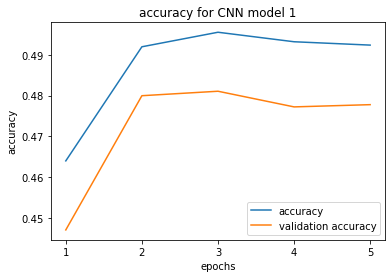

In [88]:
plot_epochs(CNN_model_1_fit, "1")

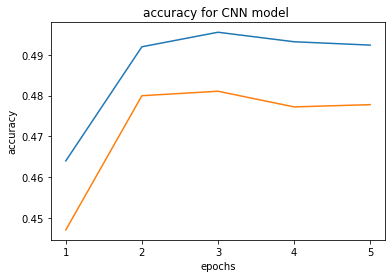

In [85]:
plot_epochs(eval("CNN_model_"+"1"+"_fit"))

AHA!  I knew I could find a way to do this:

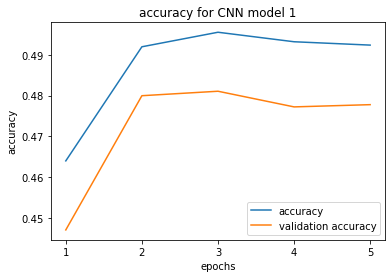

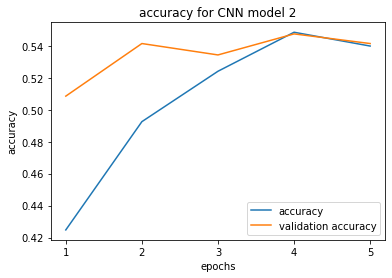

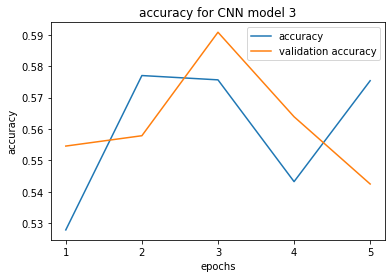

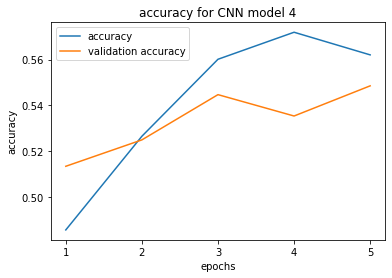

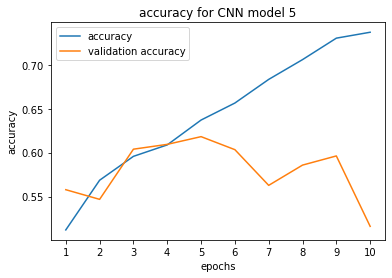

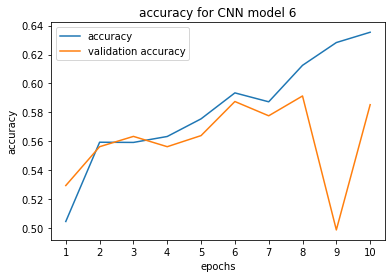

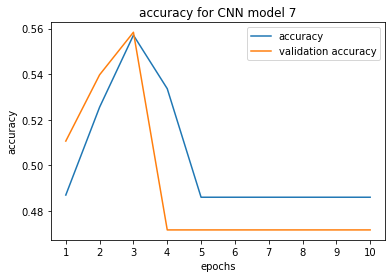

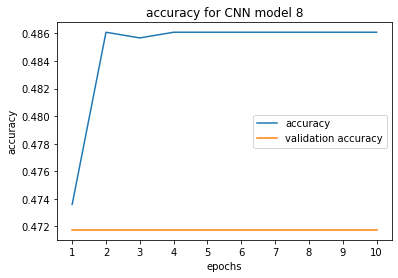

In [89]:
elist = list(range(1, 9))
for e in elist:
    stringname = "CNN_model_" + str(e) + "_fit"
    plot_epochs(eval(stringname), str(e))